# General concept
## Define Classes

In [1]:
# Source: https://github.com/KDD-OpenSource/agots/blob/master/agots/multivariate_generators/base.py
class MultivariateOutlierGenerator:
    def __init__(self, timestamps):
        self.timestamps = timestamps

    def add_outliers(self, timeseries):
        return NotImplementedError

In [65]:
# Source: https://github.com/KDD-OpenSource/agots/blob/master/agots/multivariate_generators/multivariate_variance_outlier_generator.py
class MultivariateVarianceOutlierGenerator(MultivariateOutlierGenerator):
#     def __init__(self, timestamps=None, factor=8):
    def __init__(self, timestamps=None, factor=3):
        self.timestamps = timestamps or []
        self.factor = factor

    def add_outliers(self, timeseries):
        additional_values = np.zeros(timeseries.size)
        for start, end in self.timestamps:
            difference = np.diff(timeseries[start-1:end]) if start > 0 \
                         else np.insert(np.diff(timeseries[start:end]), 0, 0)
            additional_values[list(range(start, end))] += (self.factor - 1) * difference
        return additional_values

In [3]:
# Source: https://github.com/KDD-OpenSource/agots/blob/master/agots/multivariate_generators/multivariate_extreme_outlier_generator.py
class MultivariateExtremeOutlierGenerator(MultivariateOutlierGenerator):
    def __init__(self, timestamps=None, factor=8):
        self.timestamps = [] if timestamps is None else list(sum(timestamps, ()))
        self.factor = factor

    def get_value(self, current_timestamp, timeseries):
        if current_timestamp in self.timestamps:
            local_std = timeseries.iloc[max(0, current_timestamp - 10):current_timestamp + 10].std()
            return np.random.choice([-1, 1]) * self.factor * local_std
        else:
            return 0

    def add_outliers(self, timeseries):
        additional_values = []
        for timestamp_index in range(len(timeseries)):
            additional_values.append(self.get_value(timestamp_index, timeseries))
        return additional_values

In [4]:
# Source: https://github.com/KDD-OpenSource/agots/blob/master/agots/multivariate_generators/multivariate_shift_outlier_generator.py
class MultivariateShiftOutlierGenerator(MultivariateOutlierGenerator):
    def __init__(self, timestamps=None, factor=8):
        timestamps = timestamps or []
        self.timestamps = timestamps
        self.factor = factor

    def add_outliers(self, timeseries):
        additional_values = np.zeros(timeseries.size)
        for start, end in self.timestamps:
            local_std = timeseries.iloc[max(0, start - 10):end + 10].std()
            additional_values[list(range(start, end))] += np.random.choice([-1, 1]) * self.factor * local_std
        return additional_values

In [5]:
# Source: https://github.com/KDD-OpenSource/agots/blob/master/agots/multivariate_generators/multivariate_trend_outlier_generator.py
class MultivariateTrendOutlierGenerator(MultivariateOutlierGenerator):
    def __init__(self, timestamps=None, factor=8):
        self.timestamps = timestamps or []
        self.factor = factor / 10  # Adjust for trend

    def add_outliers(self, timeseries):
        additional_values = np.zeros(timeseries.size)
        for start, end in self.timestamps:
            slope = np.random.choice([-1, 1]) * self.factor * np.arange(end - start)
            additional_values[list(range(start, end))] += slope
            additional_values[end:] += slope[-1]
        return additional_values

In [6]:
# Source: https://github.com/KDD-OpenSource/agots/blob/master/agots/multivariate_generators/multivariate_data_generator.py
INITIAL_VALUE_MIN = 0
INITIAL_VALUE_MAX = 1

class MultivariateDataGenerator:
    def __init__(self, stream_length, n, k, shift_config=None, behavior=None, behavior_config=None):
        """Create multivariate time series using outlier generators
        :param stream_length: number of values in each time series
        :param n: number of time series at all
        :param k: number of time series that should correlate. If all should correlate with the first
        one, set k=n.
        :param shift_config: dictionary from index of the time series to how much it should be displaced in time (>=0)
        """

        if not shift_config:
            self.shift_config = {}
            self.max_shift = 0
        else:
            self.shift_config = shift_config
            self.max_shift = max(list(self.shift_config.values()))
        self.behavior = behavior
        self.behavior_config = behavior_config if behavior_config is not None else {}

        self.STREAM_LENGTH = stream_length
        self.N = n
        self.K = k
        self.data = pd.DataFrame()
        self.outlier_data = pd.DataFrame()

        assert self.STREAM_LENGTH > 0, 'stream_length must at least be 1'
        assert self.N > 0, 'n must at least be 1'
        assert self.K >= 0, 'k must at least be 0'
        assert self.K <= self.N, 'k must be less than or equal to n'
        assert 0 not in self.shift_config.keys(), 'The origin time series cannot be shifted in time'

        if k == 0:  # There is no difference between k=0 and k=1.
            self.K = 1
            
    def generate_baseline(self, correlation_min=0.9, correlation_max=0.7, initial_value_min=INITIAL_VALUE_MIN,
                          initial_value_max=INITIAL_VALUE_MAX):
        """
        Generate the multivariate data frame
        :param correlation_min: how much the k columns should at least correlate with the first one
        :param correlation_max: how much the n-k-1 columns should at max correlate with the first one
        :param initial_value_min: minimal possible value of the first entry of the time series
        :param initial_value_max: maximal possible value of the first entry of the time series
        :return: a DataFrame with columns ['timestamp', 'x0', ... 'xn-1'] in which the first column
        is the original time series. The following k columns correlate at least with correlation_min
        with it and the remaining n-k columns correlate at max correlation_max with it.
        """

        df = self.init_dataframe(self.N)
        # Create k correlating time series
        df = self.create_correlating_time_series(self.K, correlation_min, df, initial_value_min, initial_value_max)

        # Create the remaining n - k time series randomly
        df = self.create_not_correlating_time_series(self.K, self.N, correlation_max, df, initial_value_min,
                                                     initial_value_max)

        # Perform the shifts: currently all time series have n+max_shift elements
        # Each one should start at index max_shift - own_shift such that the padded measurements of a time series before
        # the origin time series starts descend from a self-correlating distribution
        for k, column_name in enumerate(df.columns):
            own_shift = 0 if k not in self.shift_config.keys() else self.shift_config[k]
            df[column_name] = df[column_name].shift(own_shift)

        df.dropna(axis=0, inplace=True)
        df.reset_index(inplace=True, drop=True)

        assert not df.isnull().values.any(), 'There is at least one NaN in the generated DataFrame'
        self.data = df
        return self.data
    
    def init_dataframe(self, number_time_series):
        columns = ['timestamp']
        for value_column_index in range(number_time_series):
            columns.append('x{}'.format(value_column_index))
        df = pd.DataFrame(columns=columns)
        return df
    
    def create_basic_time_series(self, df, initial_value_min=INITIAL_VALUE_MIN, initial_value_max=INITIAL_VALUE_MAX):
        if initial_value_min != initial_value_max:
            start = np.random.randint(initial_value_min, initial_value_max)
        else:
            start = initial_value_min

        if self.behavior is not None:
            behavior_generator = self.behavior(**self.behavior_config)

        # Create basic time series
        x = [start]
        timestamps = [0]
        for i in range(1, self.STREAM_LENGTH + self.max_shift):
            timestamps.append(i)
            value = x[i - 1] + np.random.normal(0, 1)
            if self.behavior is not None:
                value += next(behavior_generator)
            x.append(value)
        df['x0'] = x
        df['timestamp'] = timestamps
        df.set_index('timestamp', inplace=True)
        return df
    
    def create_correlating_time_series(self, number_time_series, correlation_min, df,
                                       initial_value_min=INITIAL_VALUE_MIN,
                                       initial_value_max=INITIAL_VALUE_MAX):
        # First time series
        df = self.create_basic_time_series(df=df, initial_value_min=initial_value_min,
                                           initial_value_max=initial_value_max)
        origin_offset = df.iloc[0, 0]

        # number_time_series time series which are correlating
        for index_correlating in range(1, number_time_series):
            while True:
                x = [0]
                if initial_value_min != initial_value_max:
                    offset = np.random.randint(initial_value_min, initial_value_max)
                else:
                    offset = initial_value_min
                for index_timeseries_length in range(self.STREAM_LENGTH - 1 + self.max_shift):
                    # Take 50% of time series 0 and add 50% randomness
                    original_value = df.iloc[index_timeseries_length, 0] - origin_offset
                    x.append(0.5 * original_value + 0.5 * (np.random.random() - 0.5))
                df['x' + str(index_correlating)] = x
                df['x' + str(index_correlating)] += offset
                if abs(df.corr().iloc[0, index_correlating]) >= correlation_min:
                    break
            assert (len(df) == self.STREAM_LENGTH + self.max_shift)
        return df

    def create_not_correlating_time_series(self, k, n, correlation_max, df, initial_value_min=INITIAL_VALUE_MIN,
                                           initial_value_max=INITIAL_VALUE_MAX):
        for index_not_correlation in range(k, n):
            if self.behavior is not None:
                behavior_generator = self.behavior(**self.behavior_config)
            while True:
                if initial_value_min != initial_value_max:
                    x = [np.random.randint(initial_value_min, initial_value_max)]
                else:
                    x = [initial_value_min]
                for index_timeseries_length in range(self.STREAM_LENGTH - 1 + self.max_shift):
                    value = x[index_timeseries_length] + (np.random.random() - 0.5)
                    if self.behavior is not None:
                        value += next(behavior_generator)
                    x.append(value)
                df['x' + str(index_not_correlation)] = x
                if abs(df.corr().iloc[0, index_not_correlation]) <= correlation_max:
                    break
            assert(len(df) == self.STREAM_LENGTH + self.max_shift)
        return df
    
    def add_outliers(self, config):
        """Adds outliers based on the given configuration to the base line
         :param config: Configuration file for the outlier addition e.g.
         {'extreme': [{'n': 0, 'timestamps': [(3,)]}],
          'shift':   [{'n': 3, 'timestamps': [(4,10)]}]}
          would add an extreme outlier to time series 0 at timestamp 3 and a base shift
          to time series 3 between timestamps 4 and 10
         :return:
         """
        OUTLIER_GENERATORS = {
            'extreme': MultivariateExtremeOutlierGenerator,
            'shift': MultivariateShiftOutlierGenerator,
            'trend': MultivariateTrendOutlierGenerator,
            'variance': MultivariateVarianceOutlierGenerator
        }

        generator_keys = []

        # Validate the input
        for outlier_key, outlier_generator_config in config.items():
            assert outlier_key in OUTLIER_GENERATORS, 'outlier_key must be one of {} but was'.format(OUTLIER_GENERATORS,
                                                                                                     outlier_key)
            generator_keys.append(outlier_key)
            for outlier_timeseries_config in outlier_generator_config:
                n, timestamps = outlier_timeseries_config['n'], outlier_timeseries_config['timestamps']
                assert n in range(self.N), 'n must be between 0 and {} but was {}'.format(self.N - 1, n)
                for timestamp in list(sum(timestamps, ())):
                    assert timestamp in range(
                        self.STREAM_LENGTH), 'timestamp must be between 0 and {} but was {}'.format(self.STREAM_LENGTH,
                                                                                                    timestamp)

        df = self.data
        if self.data.shape == (0, 0):
            raise Exception('You have to first compute a base line by invoking generate_baseline()')
        for generator_key in generator_keys:
            for outlier_timeseries_config in config[generator_key]:
                n, timestamps = outlier_timeseries_config['n'], outlier_timeseries_config['timestamps']
                generator_args = dict([(k, v) for k, v in outlier_timeseries_config.items() if k not in ['n', 'timestamps']])
                generator = OUTLIER_GENERATORS[generator_key](timestamps=timestamps, **generator_args)
                df[df.columns[n]] += generator.add_outliers(self.data[self.data.columns[n]])

        assert not df.isnull().values.any(), 'There is at least one NaN in the generated DataFrame'
        self.outlier_data = df
        return df

## Generate Data

In [78]:
# Source: https://github.com/KDD-OpenSource/agots/blob/master/examples/Multivariate%20Data%20Synthesis.ipynb
import numpy as np
import pandas as pd

np.random.seed(1337)

STREAM_LENGTH = 200
N = 4
K = 2

dg = MultivariateDataGenerator(STREAM_LENGTH, N, K)
df = dg.generate_baseline(initial_value_min=-4, initial_value_max=4)

## Visualize

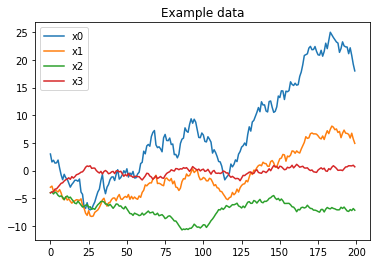

In [79]:
# Source: https://github.com/KDD-OpenSource/agots/blob/master/examples/Multivariate%20Data%20Synthesis.ipynb
import matplotlib.pyplot as plt
def draw(df,  title="Example data"):
    for col in df.columns:
        plt.plot(df[col], label=col)
    plt.legend()
    plt.title(title)
    plt.show()

#     df.corr()
draw(df)

## Add anomalies and visualize

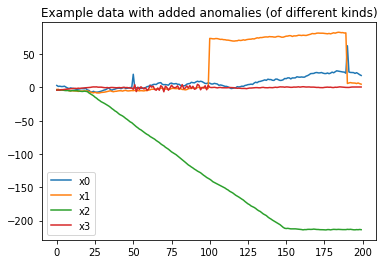

In [81]:
# Source: https://github.com/KDD-OpenSource/agots/blob/master/examples/Multivariate%20Data%20Synthesis.ipynb
df = dg.add_outliers({
    'extreme': [{'n': 0, 'timestamps': [(50,), (190,)]}],
    'shift':   [{'n': 1, 'timestamps': [(100,190)]}],
    'trend':   [{'n': 2, 'timestamps': [(20, 150)]}],
    'variance':[{'n': 3, 'timestamps': [(50, 100)]}]}
)
draw(df, 'Example data with added anomalies (of different kinds)')


# Example data that might be useful

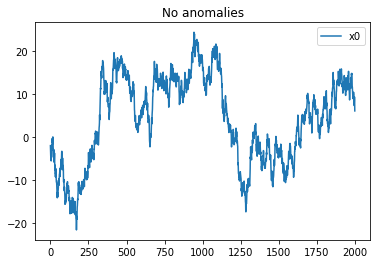

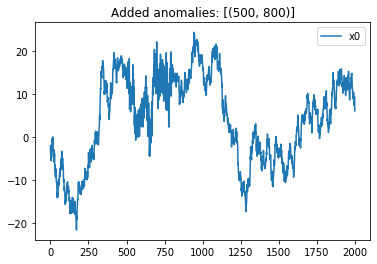

In [88]:
# Regenerate the data, to avoid adding on the already manipulated data (which has anomalies already)
STREAM_LENGTH = 2000
N, K = 1, 1
dg = MultivariateDataGenerator(STREAM_LENGTH, N, K)
df = dg.generate_baseline(initial_value_min=-4, initial_value_max=4)
draw(df, 'No anomalies')
# Add anomaly/anomalies
anomaly_sections = [(500, 800)]
df = dg.add_outliers({'variance':[{'n': 0, 'timestamps': anomaly_sections}]})
draw(df, 'Added anomalies: ' + str(anomaly_sections))